In [73]:
import pandas as pd
import numpy as np
import sklearn.datasets as dataset
import matplotlib.pyplot as plt

In [74]:
iris=dataset.load_iris()
X=iris['data'][:,(2,3)]
y=iris['target']
y[y!=1]=0

If dth < d then (dth is preset threshod for maximum tolereted degree of class imbalance ratio)
#0) Calculate the degree of imbalance
#1  Calculate the number of synthetic data examples that need to generated for minority class- G = ($m_l$ - $m_s$) * Beta
#2) where beta is number of threshold instances to be generated if Beta is 1 then fully balanced dataset will be genrated
#3) for each instance from minority class claculate the k nearest neighbors 
#4) Calculate ri=delta_i/K where delta_i is number of examples in K-nearest neighbor of $x_i$ that belongs to the majority class
#5) Normalised ri according to ricap=ri/summation over all elements in minority class ri ; so ricap is density distribution

In [94]:
def ADASYN(X,y):
    classes=np.unique(y)
    if len(y[y==classes[0]])>len(y[y==classes[1]]):
        ms=len(y[y==classes[1]])
        ml=len(y[y==classes[0]])
        minor,major=classes[1],classes[0]
    else:
        ms=len(y[y==classes[0]])
        ml=len(y[y==classes[1]])
        minor,major=classes[0],classes[1]
    d=ms/ml

    beta=1
    G=int((ml-ms)*beta)

    K=5
    X_=X[y==minor]
    KNN=np.zeros((len(X_),K)).astype(np.int)

    for i, instance in enumerate(X_):
        KNN[i]=np.argsort(np.sqrt(np.sum(np.square(instance-X[~(X==instance).all(1)]),axis=1)))[:K] #you have to X for

    ri=np.zeros(len(X_))

    for i,elem in enumerate(X[KNN]):
        total_instance=0
        for row in elem:
            total_instance+=len(np.flatnonzero((X[y==major]==row).all(1)))
        ri[i]=total_instance/K    

    if(sum(ri)!=0):    
        normalised_ri=ri/np.sum(ri)
    else:
        normalised_ri=ri

    gi=(normalised_ri*G).astype(np.int)

    si=np.zeros((np.sum(gi),X.shape[1]))
    last_index=0

    for i in range(len(gi)):
        if gi[i]!=0:
            for k in range(gi[i]):
                lambda_selector=np.random.randint(0,2)
                random_instance_selector=np.random.randint(0,K)
                xzi=X[KNN[i][random_instance_selector]]
                while (xzi==X[y==minor]).all(1).any()==False:
                    random_instance_selector=np.random.randint(0,K)
                    xzi=X[KNN[i][random_instance_selector]]
                xi=X_[i]
                si[last_index]=xi+(xzi-xi)*lambda_selector
                last_index+=1
    return si,np.full(len(si),minor)

In [98]:
X_extra,y_extra=np.append(X,ADASYN(X,y)[0],axis=0),np.append(y,ADASYN(X,y)[1])

In [108]:
from sklearn.svm import SVC
svm_clf=SVC(kernel='rbf',C=0.1,gamma='scale')
svm_clf.fit(X,y)
new_svm_clf=SVC(kernel='rbf',C=0.1,gamma='scale')
new_svm_clf.fit(X_extra,y_extra)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

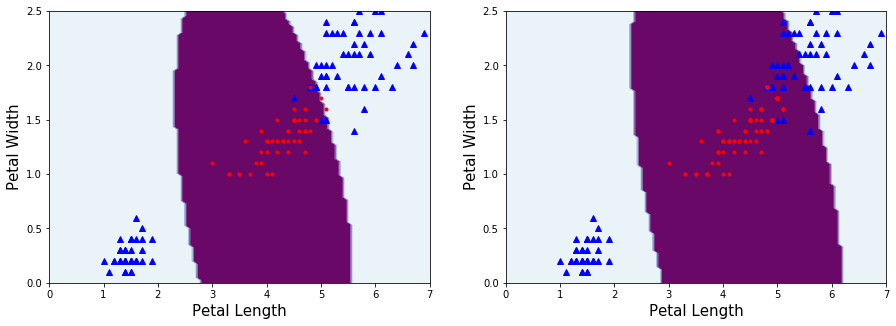

In [109]:
plt.figure(figsize=(15,5))
plt.subplot(121)
x1_=np.linspace(0,7,100)
x2_=np.linspace(0,2.5,100)
x1,x2=np.meshgrid(x1_,x2_)
X_new=np.c_[x1.ravel(),x2.ravel()]
y_predict=svm_clf.predict(X_new).reshape(x1.shape)
plt.contourf(x1,x2,y_predict,cmap=plt.cm.BuPu)
plt.plot(X[:,0][y==0],X[:,1][y==0],'b^')
plt.plot(X[:,0][y==1],X[:,1][y==1],'r.')
plt.xlabel("Petal Length", fontsize=15)
plt.ylabel("Petal Width",fontsize=15)
plt.xlim([0,7])

plt.subplot(122)
x1_=np.linspace(0,7,100)
x2_=np.linspace(0,2.5,100)
x1,x2=np.meshgrid(x1_,x2_)
X_new=np.c_[x1.ravel(),x2.ravel()]
y_predict=new_svm_clf.predict(X_new).reshape(x1.shape)
plt.contourf(x1,x2,y_predict,cmap=plt.cm.BuPu)
plt.plot(X_extra[:,0][y_extra==0],X_extra[:,1][y_extra==0],'b^')
plt.plot(X_extra[:,0][y_extra==1],X_extra[:,1][y_extra==1],'r.')
plt.xlabel("Petal Length", fontsize=15)
plt.ylabel("Petal Width",fontsize=15)
plt.xlim([0,7])

plt.show()

In [111]:
len(np.c_[X,y])

150

In [116]:
len(X[:,0][y==1])

50